In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Dinâmica de canais iônicos

$$\require{mhchem}$$       
A ideia desta atividade é simular o chaveamento (abertura / fechamento) de um canal iônico hipotético, cuja estrutura pode transicionar entre dois estados (conformações), "aberto" ou "fechado". Supomos também que as taxas de transição entre estes estados sejam dependentes do potencial de membrana − como é o caso para registros de patch clamp de canais individuais de Potássio:

<figure>
<img src="https://github.com/borismarin/sample-data/blob/master/neuro-comp/hille1992.gif?raw=true" style="width:40%">
<center><figcaption align = "center"> Corrente em canais de Potássio (Voltage Clamp). Hille, 1992. </figcaption></center>
</figure>



Sejam $\alpha_n(V)$ e $\beta_n(V)$ as taxas de transição entre o estado aberto $A$ e o fechado $F$:

$$
\ce{F <=>[\alpha_n][\beta_n] A}
$$

Por conveniência, utilizaremos as mesmas formas para $\alpha_n(V)$ e $\beta_n(V)$ que as obtidas por Hodgkin e Huxley para a ativação da condutância de potássio no axônio gigante da lula:   

In [2]:
def alpha_n(v):
    vv = v+65
    return 0.01*(10-vv)/(np.exp((10-vv)/10) - 1)

def beta_n(v):
    vv = v+65
    return 0.125*np.exp(-vv/80)

No caso do axônio da lula, os registros envolviam médias sobre um número muito grande de canais no axônio − fazendo com que a dinâmica da variável de chaveamento $n$  ("ativação da condutância de Potássio") fosse bem descrita por um relaxamento exponencial a um valor de equilíbrio controlado por $V$. Esse tipo de dinâmica é também conhecido como "carregamento de um capacitor" (elétrica) ou "cinética de primeira ordem" (química), correspondendo à equação:

$$
\frac{dn}{dt} = \frac{n_\infty - n}{\tau_n}
$$

sendo o valor estacionário $n_\infty$ e a constante temporal $\tau_n$ relacionados com as taxas $\alpha_n, \beta_n$:

$$
\tau_n = \frac{1}{\alpha_n+\beta_n} \qquad n_\infty = \frac{\alpha_n}{\alpha_n+\beta_n}
$$

In [3]:
def tau_n(v):
    return 1/(alpha_n(v)+beta_n(v))

def n_inf(v):
    return alpha_n(v)*tau_n(v)

## Solução exata (muitos canais)

Para um potencial de membrana fixo, esta equação diferencial tem solução exata:
$$
n(t) = n_0 e^{-t/\tau_n} + n_\infty(1-e^{-t/\tau_n})
$$

In [4]:
def exata_n(t, v, n0):
    ninf = n_inf(v)
    tau = tau_n(v)
    decai = np.exp(-t/tau)
    return n0 * decai + ninf * (1 - decai)

Vamos estudar um protocolo que consiste em dois niveis de voltage clamp: manter o potencial em $-80\ \mathrm{mV}$ por $10\ \mathrm{ms}$, depois subir para $-20\ \mathrm{mV}$ por $10\ \mathrm{ms}$. 

Podemos usar a função `exata_n` definida na célula anterior para fazer um gráfico da solução do problema para um número grande de canais: 

Text(0.5, 0, 'Tempo (ms)')

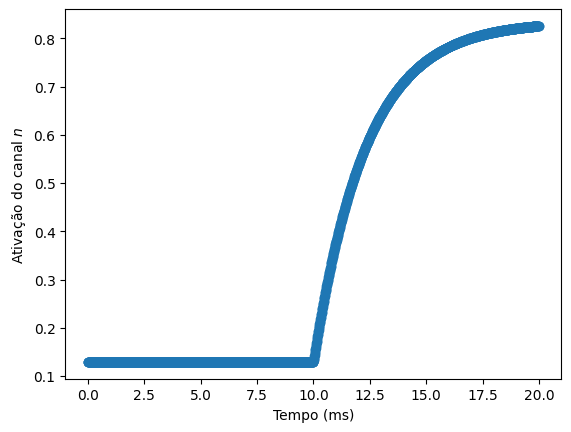

In [5]:
t0 = 0  # tempo inicial
tf = 20 # tempo final
passo = 0.01 # passo de tempo

clamp0 = -80
clamp1 = -20

t = np.arange(t0, tf, passo)  # simularemos 20 ms em passos de 0.05 ms
passos = len(t)  # total de passos dados
n = np.zeros(passos)  # espaço para guardar a solução exata n(t)

# até 10ms (metade dos passos), começamos e ficamos no valor estacionário para V = -80 mV
n[:passos//2] = n_inf(clamp0) 

# a partir de t = 10 ms, temos que calcular a solução para clamp de -20 mV
n[passos//2:] = exata_n((t[passos//2:]-10), clamp1, n_inf(clamp0))  
    
plt.figure(1)
plt.plot(t, n, 'o-')
plt.ylabel('Ativação do canal $n$')
plt.xlabel('Tempo (ms)')

## Simulando canais individuais

Vamos agora simular o chaveamento de canais individuais, que segundo os dados experimentais (vide figura acima) é um processo aleatório. Para isso, usaremos um gerador de números aleatórios uniformemente distribuidos entre 0 e 1:

(array([ 95.,  87.,  88., 104., 105.,  94., 128., 106.,  84., 109.]),
 array([0.00184765, 0.10150702, 0.20116638, 0.30082575, 0.40048511,
        0.50014448, 0.59980384, 0.69946321, 0.79912257, 0.89878194,
        0.9984413 ]),
 <BarContainer object of 10 artists>)

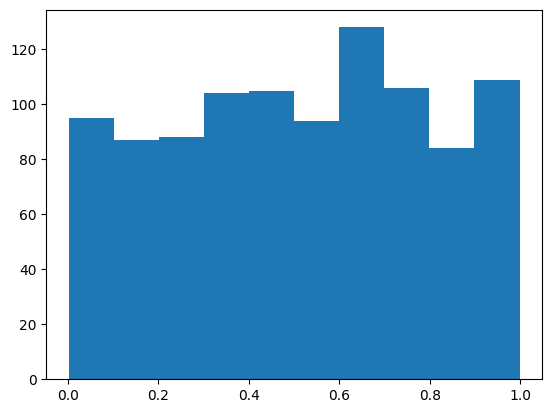

In [6]:
aleatorios = np.random.rand(1000)  # gera 1000 numeros aleatórios entre 0 e 1

plt.figure(2)
plt.hist(aleatorios, 10)  # histograma -- deve dar próximo de uniforme

De posse de um número $x$ entre 0 e 1, podemos decidir se um evento cuja probabilidade é $P$ ocorre simplesmente verificando se $x < P$. No caso, como tratam-se eventos (abertura ou fechamento) ocorrendo de forma contínua no tempo (com um passo de simulação $\Delta t$), podemos então decidir sobre a abertura/fechamento fazendo:
- se o canal está fechado, e  $x<\alpha_n(V) \Delta t$, ele se abre
- se o canal está aberto, e  $x<\beta_n(V) \Delta t$, ele se fecha.

Vamos então escrever uma função que decide se ocorre mudança no estado do canal ("aberto" representado pelo número 1, "fechado" pelo número 0) num intervalo curto de tempo, dado o estado atual e as probabilidade de abertura e fechamento.


## Simulando um canal

In [7]:
def atualiza_canal(estado, prob_abre, prob_fecha, dt):
    r = np.random.rand()
    if estado == 0:
        if r < prob_abre * dt:
            estado = 1
    else:
        if r < prob_fecha * dt:
            estado = 0

    return estado

Vamos testar essa função para dez mil passos, mantendo o potencial de membrana fixo em $-80\ \mathrm{mV}$:

Text(0.5, 0, 'Passos')

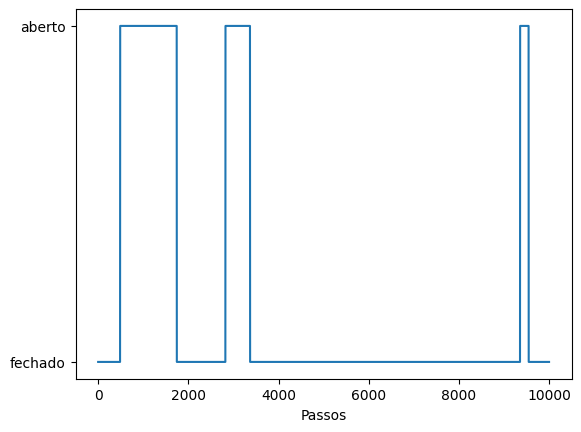

In [12]:
estado = 0  # canal começa fechado
vclamp = -80
estados = np.zeros(10000) 

for i in range(9999):
    estados[i+1] = atualiza_canal(estados[i], alpha_n(vclamp), beta_n(vclamp), dt=passo)

plt.figure(3)
plt.plot(estados, '-')
plt.yticks((0,1),('fechado', 'aberto'))
plt.xlabel('Passos')

O resultado acima variará para cada vez que você executar a célula, já que depende de um número aleatório. Mas deve ser fácil de perceber que este canal passa muito pouco tempo no estado "aberto", para o potencial de membrana fixo em $-80\ \mathrm{mV}$.

Vamos agora generalizar a lógica acima, para poder fazer a simulação com o potencial de membrana variando no  tempo. A função `simula_canal` deve receber o estado incial do canal, bem como uma lista de potenciais de membrana em cada passo, e chamar a função `atualiza_canal` (definida logo acima) a cada passo de tempo, armazenando os resultados:

In [13]:
def simula_canal(inicial, V, passos, passo):
    estados = np.zeros(passos)
    estados[0] = inicial
    estado = estados[0]
    for i in range(passos - 1):
        estado = atualiza_canal(estado, alpha_n(V[i]), beta_n(V[i]), passo)
        estados[i+1] = estado
    return estados

Estamos agora prontos para simular o canal por vários passos, com $V$ variando:

Text(0.5, 0, 'Tempo (ms)')

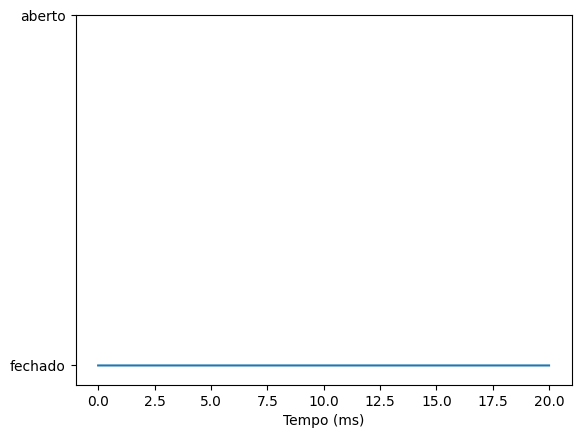

In [28]:
V = np.ones(passos) * clamp0  # aqui criamos os valores do potencial de membrana:
V[t>10] = clamp1              # metade inicial em clamp0 e final em clamp1

estado_inicial = 0  # canal começa "fechado"
estados = simula_canal(estado_inicial, V, passos, passo)

plt.figure(4)
plt.plot(t, estados, '-')
plt.yticks((0,1),('fechado', 'aberto'))
plt.xlabel('Tempo (ms)')


Pondere agora sobre o resultado obtido. O que acontece mediante a mudança no potencial de membrana em $t=10\ \mathrm{ms}$? Note que este é o resultado para apenas um canal, e que cada vez que você repetir a simulação (faça isso!), obterá um resultado diferente.

Vamos agora ver o que acontence se tivermos vários desses canais, simplesmente fazendo a simulação para cada um deles e somando o resultado (assim como a corrente iônica deve se somar). Compararemos também o resultado com a solução exata obtida no início deste documento:

## Simulando vários canais

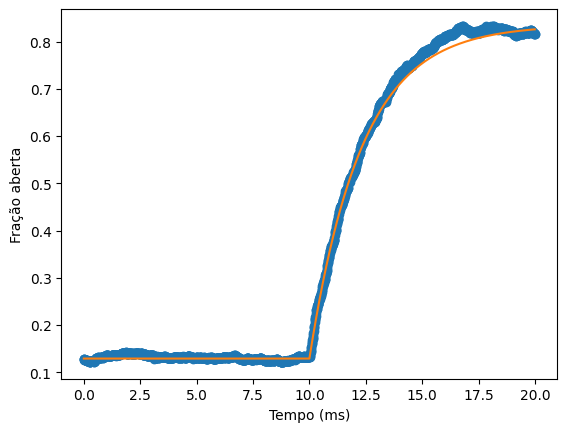

In [31]:
quantos_canais = 1000
abertos = np.zeros(len(t))  # guardamos o número de canais abertos a cada passo aqui
for i in range(quantos_canais):
    if np.random.rand() < n_inf(clamp0): #inicializa segundo fração de canais abertos
        estado_inicial = 1
    else:
        estado_inicial = 0
    abertos = abertos + simula_canal(estado_inicial, V, passos, passo)
abertos = abertos/quantos_canais  # fração de canais abertos

plt.figure()
plt.plot(t,abertos, 'o-')
plt.ylabel('Fração aberta')
plt.xlabel('Tempo (ms)')

plt.plot(t, n)  # solução exata para comparação